<a href="https://colab.research.google.com/github/AlexandreSaldanha/MVP_PUC_RIO/blob/main/MVP_de_Engenharia_de_Dado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MVP de Engenharia de Dados**

# Alexandre Pereira Saldanha

# **OBJETIVO:**
No final, os dados devem estar adequados ao modelo de dados relacional para consultar e analisar quantidade vendida? Quais produtos? Quais categorias? Em quais datas foram vendidas?

# **Como será nosso processo?**

**PIPELINE**
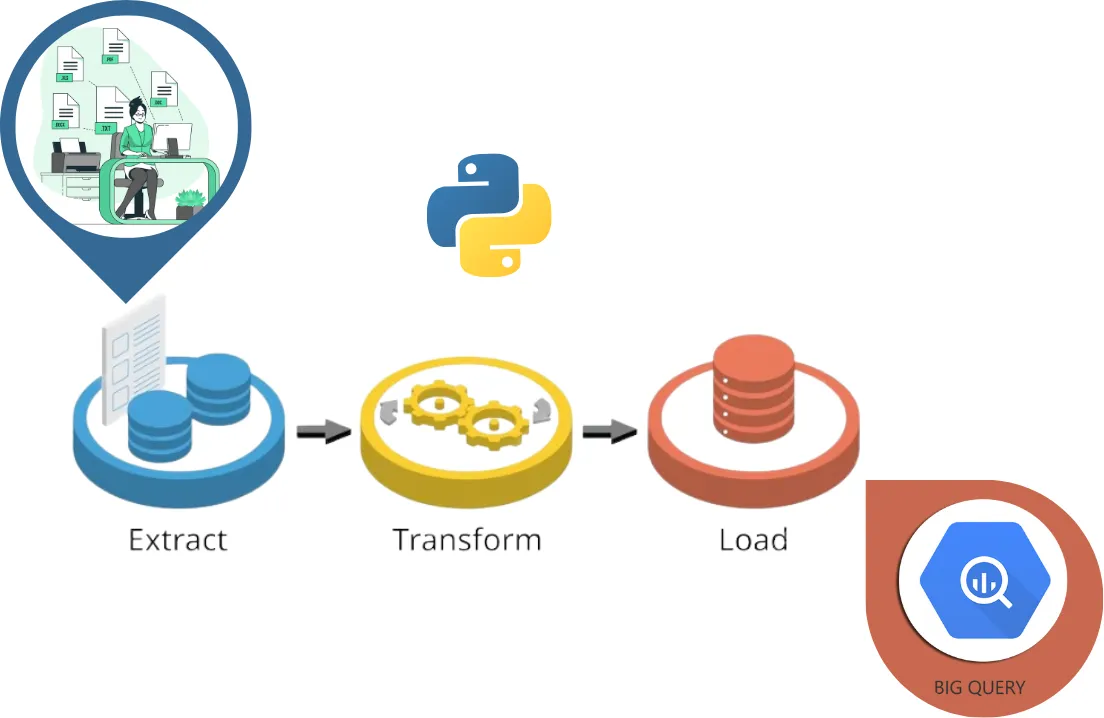



*   **Extração (Extract):** Para a Extração, nossa origem dos dados será um arquivo flat, com extensão .XLSX (Excel, Google Sheets), com dados comerciais reais de uma empresa.

*   **Transformação (Transform):** Nesta etapa realizaremos as verificações, adequações, tratamentos e ajustes necessários para garantir consistência e qualidade aos dados.

*   **Carregamento (Load):** Realizaremos as inserções dos dados no Google BigQuery, onde será possível fazer consultas e análises.

*  Para todas as etapas, **Extração, Transformação e Carregamento**, utilizaremos a linguagem de programação **Python**.



# **1.  Extração dos dados (Extract)**
Após a importação da biblioteca Pandas, utiliza-se o método .read_excel() para carregar nossa planilha no Dataframe.

In [1]:
# Importando as bibliotecas
import pandas as pd

In [ ]:
# Faz a leitura da planilha para o dataframe
df = pd.read_excel('Dados_Comerciais.xlsx')
df.head()

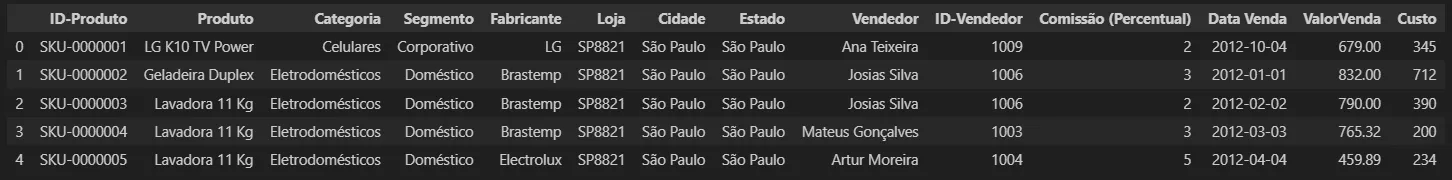

Dataframe Dados Comerciais


# **2**.   **Transformação dos Dados (Transform)**
Realizaremos todos os tratamentos e ajustes necessários para que os dados no final, estejam na estrutura de dados relacional definida.

Verificações: Tamanho do Dataframe, Estrutura de dados, Valores Ausentes e Registros Duplicados



In [ ]:
# Verifica o tamanho do Dataframe (linhas,colunas)
df.shape

In [ ]:
# Exibe a descrição da estrutura dos dados do nosso Dataframe
df.info()

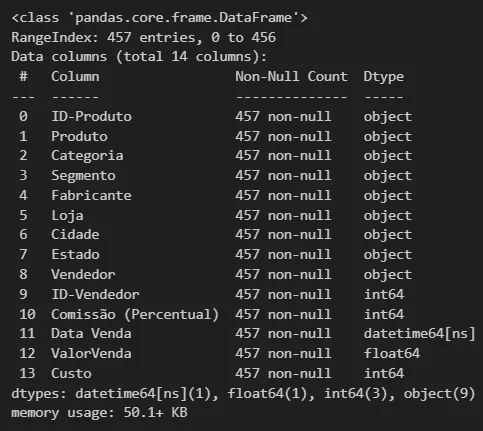

Nosso Dataframe possui (457 linhas, 14 colunas)

In [ ]:
# Verifica a existencia de dados nulos
def valores_ausentes(df):
    return df.isna().agg(['sum', lambda x : (x.sum() / df.shape[0]) * 100]).T.rename(columns={'sum':'valores ausentes','<lambda>':'porcentagem'})[df.isna().sum() > 0]

In [ ]:
# Mostra valores ausentes no dataframe
valores_ausentes(df)

Nosso dataframe não possui valores ausentes.

In [ ]:
# Verifica registros com valores duplicados
df.duplicated().sum()

Nosso dataframe não possui registros com valores duplicados.

Será necessário a criação de vários **Dataframes** para representar o modelo de dados, facilitando o processo de **Carregamento (Load)**.

*O DataFrame do Pandas é uma maneira de representar e trabalhar com dados tabulares. Ele pode ser visto como uma tabela que organiza os dados em linhas e colunas, criando uma estrutura de dados bidimensional. Um DataFrame pode ser criado do zero ou você pode usar outras estruturas de dados, como matrizes NumPy.*

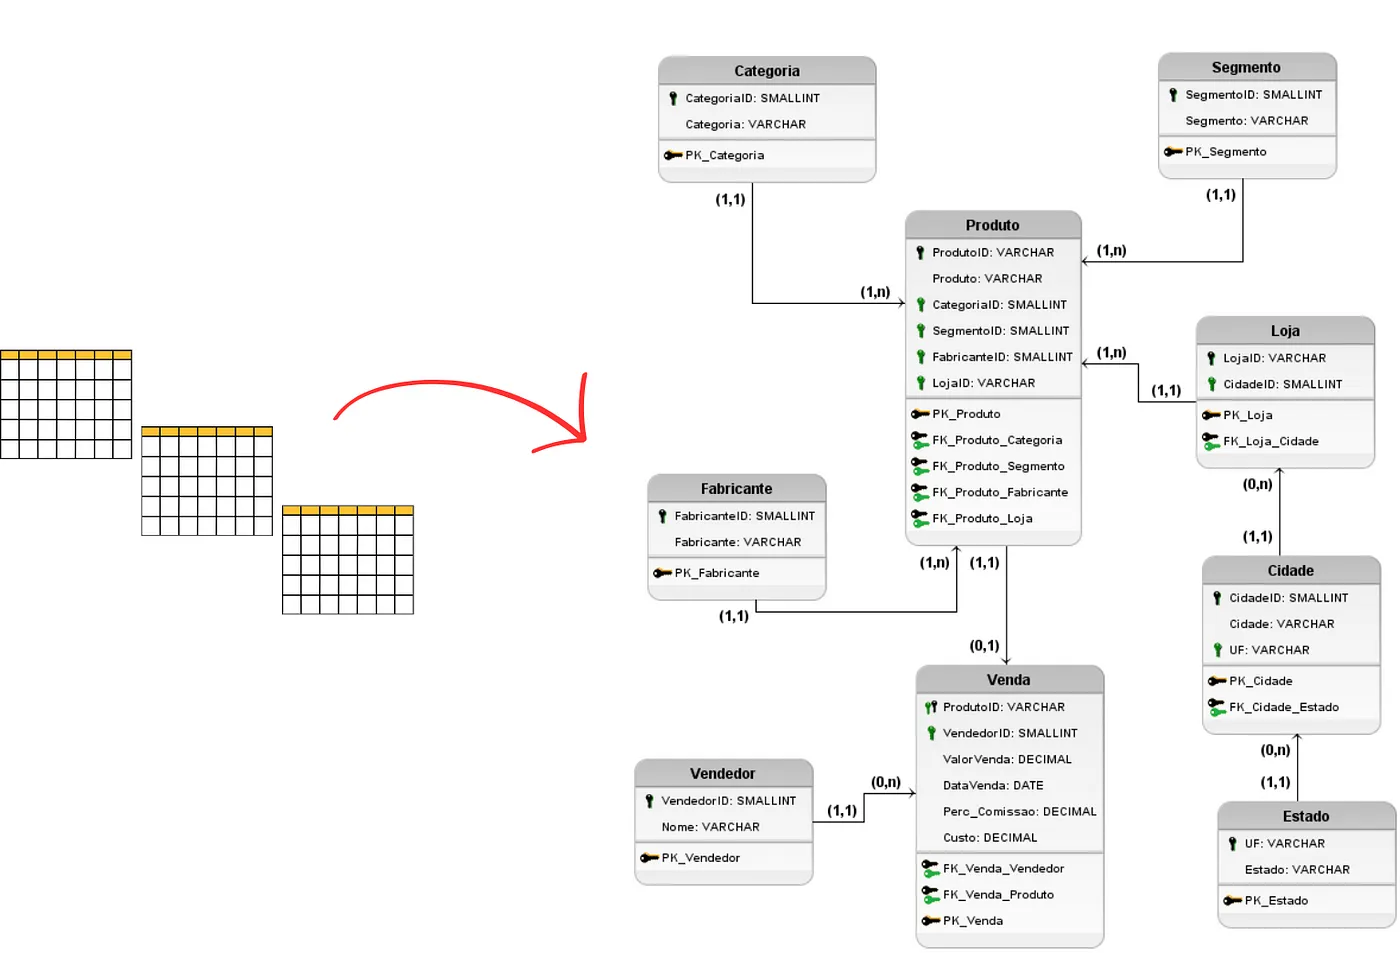

Criação dos Dataframes na estrutura do modelo físico de dados.

**Categoria**

In [ ]:
# Dataframe Categoria
df_categoria = pd.DataFrame(columns=['categoriaid','categoria'])
df_categoria['categoria'] = df['Categoria'].value_counts().index
df_categoria['categoriaid'] = range(1,df_categoria.shape[0]+1)
df_categoria

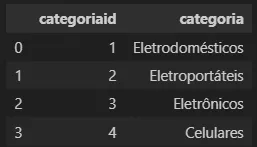

**Segmento**

In [ ]:
# Dataframe Segmento
df_segmento = pd.DataFrame(columns=['segmentoid','segmento'])
df_segmento['segmento'] = df['Segmento'].value_counts().index
df_segmento['segmentoid'] = range(1,df_segmento.shape[0]+1)
df_segmento

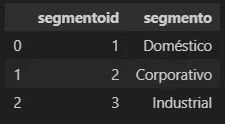

**Fabricante**

In [ ]:
# Dataframe Fabricante
df_fabricante = pd.DataFrame(columns=['fabricanteid','fabricante'])
df_fabricante['fabricante'] = df['Fabricante'].value_counts().index
df_fabricante['fabricanteid'] = range(1,df_fabricante.shape[0]+1)
df_fabricante

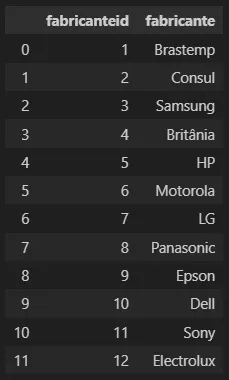

**Estados (UF)**

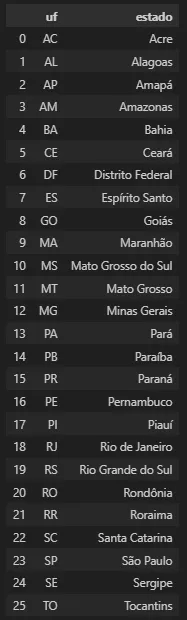

**Cidade**

In [ ]:
# Dataframe Cidade
df_cidade = pd.DataFrame(columns=['cidadeid','cidade', 'estado','uf'])
df_cidade['cidade'] = df.groupby(by='Cidade')['Estado'].value_counts().index.get_level_values(0)
df_cidade['cidadeid'] = range(1,df_cidade.shape[0]+1)
df_cidade["estado"] = df.groupby(by='Cidade')['Estado'].value_counts().index.get_level_values(1)
df_cidade = df_cidade.set_index('estado').combine_first(df_uf[df_uf['estado'].isin(df_cidade['estado'])].set_index('estado')) # UF
df_cidade.reset_index(inplace=True)
df_cidade[['cidadeid','cidade', 'estado','uf']]

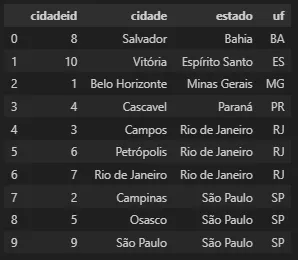

**Temp (Dataframe intermediário para buscar as informações das tabelas de cadastros)**

In [ ]:
# Dataframe temporario para buscar as informações das tabelas de cadastros
df_temp = pd.DataFrame(columns=['produtoid','produto','categoriaid','categoria','segmentoid','segmento','fabricanteid','fabricante','loja','cidadeid','cidade','estado','uf','vendedor','vendedorid','datavenda','valorvenda','comissao','custo'])
df_temp['produtoid'] = df['ID-Produto']
df_temp['produto'] = df['Produto']
df_temp['categoria'] = df['Categoria']
df_temp['segmento'] = df['Segmento']
df_temp['fabricante'] = df['Fabricante']
df_temp['loja'] = df['Loja']
df_temp['cidade'] = df['Cidade']
df_temp['estado'] = df['Estado']
df_temp['vendedor'] = df['Vendedor']
df_temp['vendedorid'] = df['ID-Vendedor']
df_temp['datavenda'] = df['Data Venda']
df_temp['valorvenda'] = df['ValorVenda']
df_temp['comissao'] = df['Comissão (Percentual)']
df_temp['custo'] = df['Custo']
df_temp = df_temp.set_index('categoria').combine_first(df_categoria.set_index('categoria')) # CategoriaID
df_temp.reset_index(inplace=True)
df_temp = df_temp.set_index('segmento').combine_first(df_segmento.set_index('segmento')) # SegmentoID
df_temp.reset_index(inplace=True)
df_temp = df_temp.set_index('fabricante').combine_first(df_fabricante.set_index('fabricante')) # FabricanteID
df_temp.reset_index(inplace=True)
df_temp.reset_index(inplace=True)
df_temp = df_temp.set_index('cidade').combine_first(df_cidade.set_index('cidade')) # CidadeID, UF
df_temp.reset_index(inplace=True)

df_temp[['produtoid','produto','categoriaid','categoria','segmentoid','segmento','fabricanteid','fabricante','loja','cidadeid','cidade','estado','uf','vendedor','vendedorid','datavenda','valorvenda','comissao','custo']]

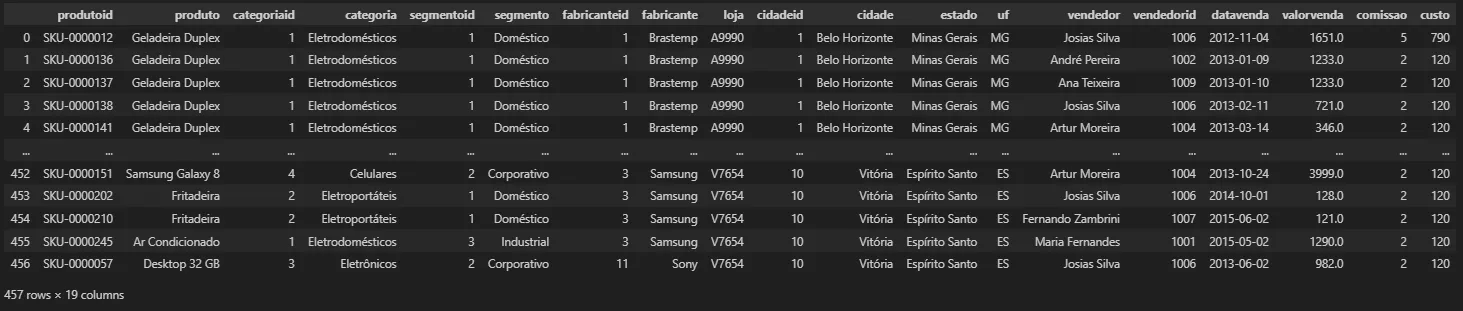

**Loja**

In [ ]:
# Dataframe Loja
df_loja = pd.DataFrame(columns=['lojaid','cidadeid'])
df_loja['lojaid'] = df_temp.groupby(by='loja')['cidade'].value_counts().index.get_level_values(0)
df_loja['cidadeid'] = df_temp.groupby(by='loja')['cidadeid'].value_counts().index.get_level_values(1)
df_loja

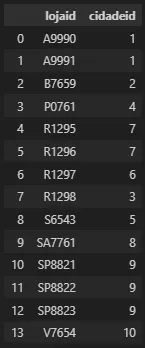

**Vendedor**

In [ ]:
# Dataframe Vendedor
df_vendedor = pd.DataFrame(columns=['vendedorid','nome'])
df_vendedor['nome'] = df.groupby(by=['ID-Vendedor'])['Vendedor'].value_counts().index.get_level_values(1)
df_vendedor['vendedorid'] = df.groupby(by=['ID-Vendedor'])['Vendedor'].value_counts().index.get_level_values(0)
df_vendedor

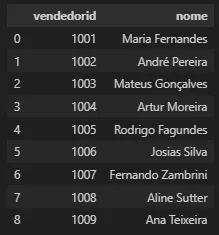

**Produto**

In [ ]:
# Dataframe Produto
df_produto = pd.DataFrame(columns=['produtoid','produto','categoriaid','categoria','segmentoid','segmento','fabricanteid','fabricante','lojaid'])
df_produto['produtoid'] = df_temp['produtoid']
df_produto['produto'] = df_temp['produto']
df_produto['categoria'] = df_temp['categoria']
df_produto['categoriaid'] = df_temp['categoriaid']
df_produto['segmento'] = df_temp['segmento']
df_produto['segmentoid'] = df_temp['segmentoid']
df_produto['fabricante'] = df_temp['fabricante']
df_produto['fabricanteid'] = df_temp['fabricanteid']
df_produto['lojaid'] = df_temp['loja']
df_produto

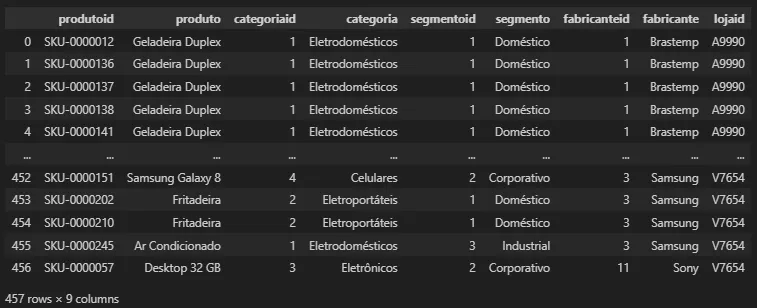

**Venda**

In [ ]:
# Dataframe Venda
df_venda = pd.DataFrame(columns=['produtoid','produto','vendedorid','vendedor','datavenda','valorvenda','comissao','custo'])
df_venda['produtoid'] = df_temp['produtoid']
df_venda['produto'] = df_temp['produto']
df_venda['vendedorid'] = df_temp['vendedorid']
df_venda['vendedor'] = df_temp['vendedor']
df_venda['datavenda'] = df_temp['datavenda']
df_venda['valorvenda'] = df_temp['valorvenda']
df_venda['perc_comissao'] = df_temp['comissao']
df_venda['custo'] = df_temp['custo']
df_venda

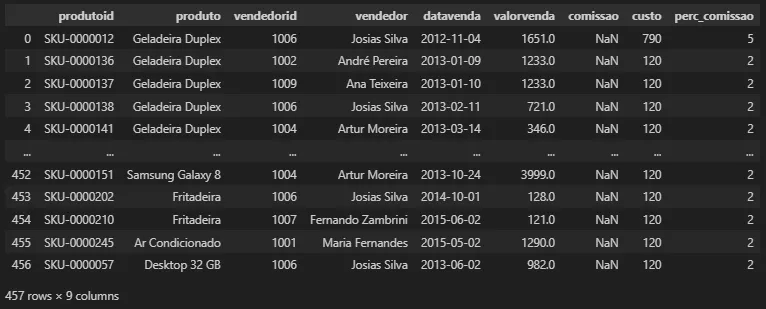



# **3.   Carregamento dos Dados (Load)**

Nesta etapa faremos as inserções dos dados no BigQuery.




In [ ]:
# Importando as bibliotecas
import pandas as pd
import os
import sys
# Bibliotecas para manipulação no BigQuery
from google.cloud import bigquery
from google.api_core.exceptions import ClientError

In [ ]:
# Credenciais para o acesso ao Google Bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path + 'application_default_credentials.json'

In [ ]:
# Define o nome do projeto e Dataset
projeto = 'bigquery-learning-417816'
dataset = 'bigquery-learning-417816.bq_dataset'

In [ ]:
# Define o projeto dentro do BigQuery e cria a conexão
client = bigquery.Client(project=projeto)

In [ ]:
Dataset(DatasetReference('bigquery-learning-417816', 'bq_dataset'))

Para auxiliar nesse processo foram desenvolvidas 3 funções:

**create_table_bq**

In [ ]:
# Cria a tabela no BigQuery
def create_table_bq(table, schema):
    try:
        table_id = bigquery.Table(f'{dataset}.{table}', schema=schema)
        table_id = client.create_table(table_id)
        print(f'Tabela {table_id} criada com sucesso.')
    except ClientError as e:
        print(f'Tabela {table_id} não foi criada. \n' + e)

**insert_bg**

In [ ]:
# Realiza a inserção dos dados na tabela
def insert_bg(schema, df, table):
    try:
        job_config = bigquery.LoadJobConfig(
        schema=schema,
        autodetect = False)

        job = client.load_table_from_dataframe(df, table, job_config=job_config)
        job.result()
        print(f'Dados inseridos com sucesso na tabela {table}')
    except ClientError as e:
        print(f'Problema(s) ao inserir dados na tabela {table}. \n' + e)

**get_tableID**

In [ ]:
# Recupera o Table ID no dataset do BigQuery
def get_tableID(table):
    try:
        return client.get_table(f'{dataset}.{table}')
    except ClientError as e:
        return None

**Tabela Categoria**

In [ ]:
# Define a estrutura de dados no BigQuery
schema_categoria=[
    bigquery.SchemaField("categoriaid", "INTEGER", mode='REQUIRED'),
    bigquery.SchemaField("categoria", "STRING")]

In [ ]:
# Cria a tabela no BigQuery
create_table_bq('categoria', schema_categoria)

Tabela bigquery-learning-417816.bq_dataset.categoria criada com sucesso.

In [ ]:
# Insere os dados na tabela no BigQuery
insert_bg(schema_categoria, df_categoria, get_tableID('categoria'))

Dados inseridos com sucesso na tabela bigquery-learning-417816.bq_dataset.categoria

**Tabela Segmento**

In [ ]:
# Define a estrutura de dados no BigQuery
schema_segmento=[
    bigquery.SchemaField("segmentoid", "INTEGER", mode='REQUIRED'),
    bigquery.SchemaField("segmento", "STRING")]

In [ ]:
# Cria a tabela no BigQuery
create_table_bq('segmento', schema_segmento)

Tabela bigquery-learning-417816.bq_dataset.segmento criada com sucesso.

In [ ]:
# Insere os dados na tabela no BigQuery
insert_bg(schema_segmento, df_segmento, get_tableID('segmento'))

Dados inseridos com sucesso na tabela bigquery-learning-417816.bq_dataset.segmento

**Tabela Fabricante**

In [ ]:
# Define a estrutura de dados no BigQuery
schema_fabricante=[
    bigquery.SchemaField("fabricanteid", "INTEGER", mode='REQUIRED'),
    bigquery.SchemaField("fabricante", "STRING")]

In [ ]:
# Cria a tabela no BigQuery
create_table_bq('fabricante', schema_fabricante)

Tabela bigquery-learning-417816.bq_dataset.fabricante criada com sucesso.

In [ ]:
# Insere os dados na tabela no BigQuery
insert_bg(schema_fabricante, df_fabricante, get_tableID('fabricante'))

Dados inseridos com sucesso na tabela bigquery-learning-417816.bq_dataset.fabricante

**Tabela Estado (UF)**

In [ ]:
# Define a estrutura de dados no BigQuery
schema_estado=[
    bigquery.SchemaField("uf", "STRING", mode='REQUIRED'),
    bigquery.SchemaField("estado", "STRING")]

In [ ]:
# Cria a tabela no BigQuery
create_table_bq('estado',schema_estado)

Tabela bigquery-learning-417816.bq_dataset.estado criada com sucesso.

In [ ]:
# Insere os dados na tabela no BigQuery
insert_bg(schema_estado, df_uf, get_tableID('estado'))

Dados inseridos com sucesso na tabela bigquery-learning-417816.bq_dataset.estado

**Tabela Cidade**

In [ ]:
# Define a estrutura de dados no BigQuery
schema_cidade=[
    bigquery.SchemaField("cidadeid", "INTEGER", mode='REQUIRED'),
    bigquery.SchemaField("cidade", "STRING"),
    bigquery.SchemaField("uf", "STRING", mode='REQUIRED')]
]

In [ ]:
# Cria a tabela no BigQuery
create_table_bq('cidade', schema_cidade)

Tabela bigquery-learning-417816.bq_dataset.cidade criada com sucesso.

In [ ]:
# Insere os dados na tabela no BigQuery
insert_bg(schema_cidade, df_cidade[['cidadeid','cidade','uf']], get_tableID('cidade'))

Dados inseridos com sucesso na tabela bigquery-learning-417816.bq_dataset.cidade

**Tabela Loja**

In [ ]:
# Define a estrutura de dados no BigQuery
schema_loja=[
    bigquery.SchemaField("lojaid", "STRING", mode='REQUIRED'),
    bigquery.SchemaField("cidadeid", "INTEGER", mode='REQUIRED')]

In [ ]:
# Cria a tabela no BigQuery
create_table_bq('loja', schema_loja)

Tabela bigquery-learning-417816.bq_dataset.loja criada com sucesso.

In [ ]:
# Insere os dados na tabela no BigQuery
insert_bg(schema_loja, df_loja, get_tableID('loja'))

Dados inseridos com sucesso na tabela bigquery-learning-417816.bq_dataset.loja

**Tabela Vendedor**

In [ ]:
# Define a estrutura de dados no BigQuery
schema_vendedor=[
    bigquery.SchemaField("vendedorid", "INTEGER", mode='REQUIRED'),
    bigquery.SchemaField("nome", "STRING")]

In [ ]:
# Cria a tabela no BigQuery
create_table_bq('vendedor', schema_vendedor)

Tabela bigquery-learning-417816.bq_dataset.vendedor criada com sucesso.

In [ ]:
# Insere os dados na tabela no BigQuery
insert_bg(schema_vendedor, df_vendedor, get_tableID('vendedor'))

Dados inseridos com sucesso na tabela bigquery-learning-417816.bq_dataset.vendedor

**Tabela Produto**

In [ ]:
 Define a estrutura de dados no BigQuery
schema_produto=[
    bigquery.SchemaField("produtoid", "STRING", mode='REQUIRED'),
    bigquery.SchemaField("produto", "STRING"),
    bigquery.SchemaField("categoriaid", "INTEGER", mode='REQUIRED'),
    bigquery.SchemaField("segmentoid", "INTEGER", mode='REQUIRED'),
    bigquery.SchemaField("fabricanteid", "INTEGER", mode='REQUIRED'),
    bigquery.SchemaField("lojaid", "STRING", mode='REQUIRED')]

In [ ]:
# Cria a tabela no BigQuery
create_table_bq('produto', schema_produto)

Tabela bigquery-learning-417816.bq_dataset.produto criada com sucesso.

In [ ]:
# Insere os dados na tabela no BigQuery
insert_bg(schema_produto, df_produto[['produtoid','produto','categoriaid','segmentoid','fabricanteid','lojaid']], get_tableID('produto'))

Dados inseridos com sucesso na tabela bigquery-learning-417816.bq_dataset.produto

**Tabela Venda**

In [ ]:
# Define a estrutura de dados no BigQuery
schema_venda=[
    bigquery.SchemaField("produtoid", "STRING", mode='REQUIRED'),
    bigquery.SchemaField("vendedorid", "INTEGER", mode='REQUIRED'),
    bigquery.SchemaField("datavenda", "DATE"),
    bigquery.SchemaField("valorvenda", "FLOAT"),
    bigquery.SchemaField("perc_comissao", "FLOAT"),
    bigquery.SchemaField("custo", "FLOAT")]

In [ ]:
# Cria a tabela no BigQuery
create_table_bq('venda', schema_venda)

Tabela bigquery-learning-417816.bq_dataset.venda criada com sucesso.

In [ ]:
# Insere os dados na tabela no BigQuery
insert_bg(schema_venda, df_venda[['produtoid','vendedorid','datavenda','valorvenda','perc_comissao','custo']], get_tableID('venda'))

Dados inseridos com sucesso na tabela bigquery-learning-417816.bq_dataset.venda

**Criação das Constraints Chave Primária (PK) e Estrangeira (FK).**

In [ ]:
ALTER TABLE bq_dataset.categoria ADD PRIMARY KEY (categoriaid) NOT ENFORCED;

ALTER TABLE bq_dataset.segmento ADD PRIMARY KEY (segmentoid) NOT ENFORCED;

ALTER TABLE bq_dataset.fabricante ADD PRIMARY KEY (fabricanteid) NOT ENFORCED;

ALTER TABLE bq_dataset.loja ADD PRIMARY KEY (lojaid) NOT ENFORCED;

ALTER TABLE bq_dataset.venda ADD PRIMARY KEY (produtoid) NOT ENFORCED;

ALTER TABLE bq_dataset.vendedor ADD PRIMARY KEY (vendedorid) NOT ENFORCED;

ALTER TABLE bq_dataset.produto ADD PRIMARY KEY (produtoid) NOT ENFORCED;

ALTER TABLE bq_dataset.estado ADD PRIMARY KEY (uf) NOT ENFORCED;

ALTER TABLE bq_dataset.cidade ADD PRIMARY KEY (cidadeid) NOT ENFORCED;

ALTER TABLE bq_dataset.loja ADD CONSTRAINT FK_Loja_Cidade
    FOREIGN KEY (cidadeid)
    REFERENCES bq_dataset.cidade (cidadeid) NOT ENFORCED;

ALTER TABLE bq_dataset.venda ADD CONSTRAINT FK_Venda_Vendedor
    FOREIGN KEY (vendedorid)
    REFERENCES bq_dataset.vendedor (vendedorid) NOT ENFORCED;

ALTER TABLE bq_dataset.venda ADD CONSTRAINT FK_Venda_Produto
    FOREIGN KEY (produtoid)
    REFERENCES bq_dataset.produto (produtoid)NOT ENFORCED;

ALTER TABLE bq_dataset.produto ADD CONSTRAINT FK_Produto_Categoria
    FOREIGN KEY (categoriaid)
    REFERENCES bq_dataset.categoria (categoriaid)NOT ENFORCED;

ALTER TABLE bq_dataset.produto ADD CONSTRAINT FK_Produto_Segmento
    FOREIGN KEY (segmentoid)
    REFERENCES bq_dataset.segmento (segmentoid) NOT ENFORCED;

ALTER TABLE bq_dataset.produto ADD CONSTRAINT FK_Produto_Fabricante
    FOREIGN KEY (fabricanteid)
    REFERENCES bq_dataset.fabricante (fabricanteid) NOT ENFORCED;

ALTER TABLE bq_dataset.produto ADD CONSTRAINT FK_Produto_Loja
    FOREIGN KEY (lojaid)
    REFERENCES bq_dataset.loja (lojaid) NOT ENFORCED;

ALTER TABLE bq_dataset.cidade ADD CONSTRAINT FK_Cidade_Estado
    FOREIGN KEY (uf)
    REFERENCES bq_dataset.estado (uf) NOT ENFORCED;

**Como ficou nosso dataset no Google BigQuery?**

Estrutura do dataset no BigQuery

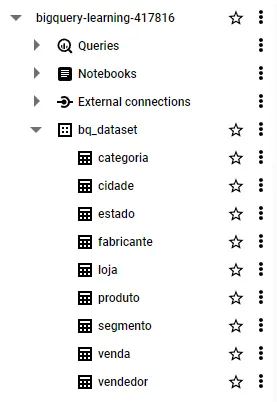

**Consultando algumas tabelas.**

Tabela categoria

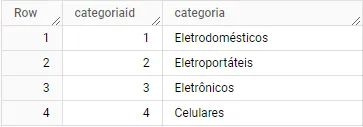

Tabela produto

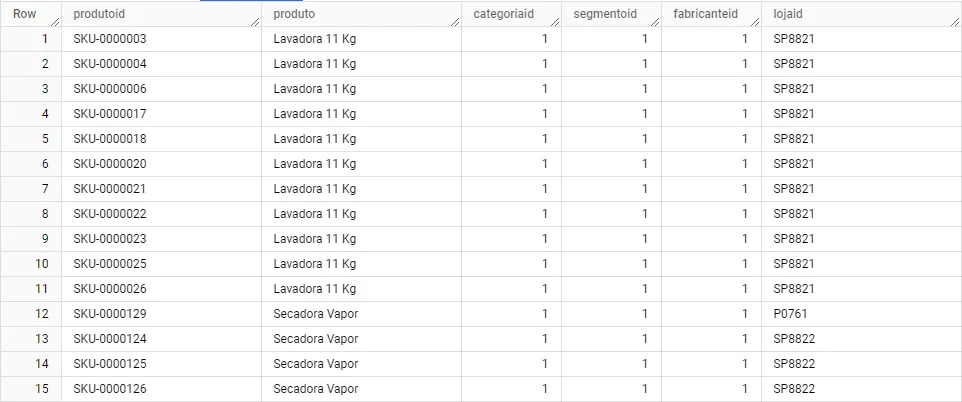

Tabela venda

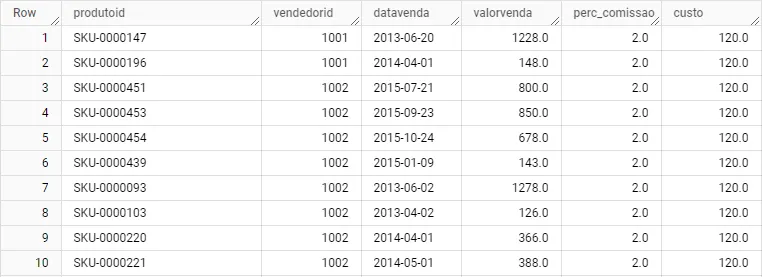

**Dados carregados com sucesso.**

# **4.   Análise**
# **a.**
Não houve problemas na qualidade dos dados. Por serem dados reais, já haviam sidos tradados previamente. Assim, não possui valores ausentes ou duplicado nos valores dos atributo.

# **b.**
A linguagem de programação Python foi usada em todas as etapas: Extração, Transformação e Carregamento, como solução do projeto.

Entretanto, a linguagem Sql foi usada para fazer as consultas nas tabelas carregadas no Google BigQuery e responder as questões traçadas nos objetivos.

As perguntas foram respondidas com acerto. Foram feitas 10 vendas, com diferentes SKU's, entre 2013 e 2015.




